## Exercise sheet 9 (Wed 17 Nov, last one!, not graded)

Some general remarks about the exercises:
* For your convenience the functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a single solution box has been added, but you may insert additional boxes above or below using `Insert > Insert cell above / below`. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`).
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* This exercise sheet will __not__ be graded, but if you may still submit it via Brightspace to receive feedback from the teaching assistant. Do this before __Wednesday 24 November 10:30__ by saving the notebook to your local computer via `File > Donwload as > Notebook (.ipynb)` and uploading to the appropriate Brightspace Assignment.

### Code from the lectures

In [2]:
import numpy as np
import matplotlib.pylab as plt
import os
%matplotlib inline

def read_all_json(directory,startswith):
    '''Read all json-files in `directory` that start with `startswith` and return the data as a list.'''
    data = []
    for filename in sorted(os.listdir(directory)):
        if filename.startswith(startswith) and filename.endswith(".json"):
            with open(os.path.join(directory,filename)) as file:
                data.append(json.load(file))
    return data

def batch_estimate(data,observable,num_batches):
    '''Determine estimate of observable on the data and its error using batching.'''
    batch_size = len(data)//num_batches
    values = [observable(data[i*batch_size:(i+1)*batch_size]) for i in range(num_batches)]
    return np.mean(values), np.std(values)/np.sqrt(num_batches-1)

## 9.1 Running code on the compute cluster: lattice scalar field

**Goal**: Learn how to scale up simulations by transitioning from running them in the notebook to stand-alone scripts on the compute cluster.

In lecture 7 we implemented the Metropolis-Hastings simulation of a lattice scalar field using the following code:

In [ ]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline

def potential_v(x,lamb):
    '''Compute the potential function V(x).'''
    return lamb*(x*x-1)*(x*x-1)+x*x

def neighbor_sum(phi,s):
    '''Compute the sum of the state phi on all 8 neighbors of the site s.'''
    w = len(phi)
    return (phi[(s[0]+1)%w,s[1],s[2],s[3]] + phi[(s[0]-1)%w,s[1],s[2],s[3]] +
            phi[s[1],(s[1]+1)%w,s[2],s[3]] + phi[s[1],(s[1]-1)%w,s[2],s[3]] +
            phi[s[0],s[1],(s[2]+1)%w,s[3]] + phi[s[0],s[1],(s[2]-1)%w,s[3]] +
            phi[s[0],s[1],s[2],(s[3]+1)%w] + phi[s[0],s[1],s[2],(s[3]-1)%w] )

def scalar_action_diff(phi,site,newphi,lamb,kappa):
    '''Compute the change in the action when phi[site] is changed to newphi.'''
    return (2 * kappa * neighbor_sum(phi,site) * (phi[site] - newphi) +
            potential_v(newphi,lamb) - potential_v(phi[site],lamb) )

def scalar_MH_step(phi,lamb,kappa,delta):
    '''Perform Metropolis-Hastings update on state phi with range delta.'''
    site = tuple(rng.integers(0,len(phi),4))
    newphi = phi[site] + rng.uniform(-delta,delta)
    deltaS = scalar_action_diff(phi,site,newphi,lamb,kappa)
    if deltaS < 0 or rng.uniform() < np.exp(-deltaS):
        phi[site] = newphi
        return True
    return False

def run_scalar_MH(phi,lamb,kappa,delta,n):
    '''Perform n Metropolis-Hastings updates on state phi and return number of accepted transtions.'''
    total_accept = 0
    for _ in range(n):
        total_accept += scalar_MH_step(phi,lamb,kappa,delta)
    return total_accept

lamb = 1.5
kappas = np.linspace(0.08,0.18,11)
width = 3
num_sites = width**4
delta = 1.5  # chosen to have ~ 50% acceptance
equil_sweeps = 800
measure_sweeps = 2
measurements = 1000

mean_magn = []
for kappa in kappas:
    phi_state = np.zeros((width,width,width,width))
    run_scalar_MH(phi_state,lamb,kappa,delta,equil_sweeps * num_sites)
    magnetizations = np.empty(measurements)
    for i in range(measurements):
        run_scalar_MH(phi_state,lamb,kappa,delta,measure_sweeps * num_sites)
        magnetizations[i] = np.mean(phi_state)
    mean, err = batch_estimate(np.abs(magnetizations),lambda x:np.mean(x),10)
    mean_magn.append([mean,err])
    print("kappa = {:.2f}, |m| = {:.3f} +- {:.3f}".format(kappa,mean,err))
    
plt.errorbar(kappas,[m[0] for m in mean_magn],yerr=[m[1] for m in mean_magn],fmt='-o')
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$|m|$")
plt.title(r"Absolute field average on $3^4$ lattice, $\lambda = 1.5$")
plt.show()

The goal will be to reproduce and extend its output (below).

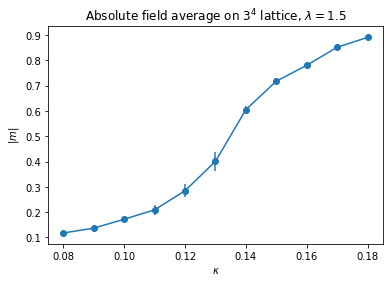

**(a)** Turn the simulation into a standalone script `latticescalar.py` (similar to `ising.py`) that takes the relevant parameters e.g.
```bash
$ python3 latticescalar.py -l 1.5 -k 0.12 -w 3 -n 1000
```
for $\lambda=1.5$, $\kappa=0.12$, $w=3$, and $1000$ measurements, together with optional parameters $\delta$ and numbers of sweeps, as command line arguments and stores the relevant simulation outcomes to a json-file.

**(b)** Write a bash script that submits jobs to the cluster for $w=3$ and $2000$ measurements and $\lambda = 1.0, 1.5,2.0$ and $\kappa = 0.08, 0.09, ..., 0.18$ (so 33 simulations in total). Submit the job to the `hefstud` slurm partition (do not run all 33 in parallel). 

**(c)** Load the stored data into this notebook and reproduce the plot above (with $\lambda = 1$ and $\lambda=2$ added).

## Feedback

Please use the following Google form to give anonymous and constructive feedback on the lecture and/or these exercises. This is an easy way to contribute to improving the course: https://forms.gle/KT1rzrnDk8MVXBPq5